<a href="https://colab.research.google.com/github/sagawritescode/ENDTwoPointOPhase1/blob/main/ERA_V1_Assignment_8_Group_Normalization_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [10]:
%matplotlib inline

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

Data Download and Transformations

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Inspect the dataset

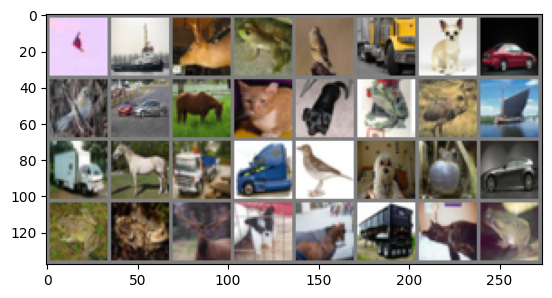

plane ship  deer  frog  bird  truck dog   car   bird  car   horse cat   dog   frog  bird  ship  truck horse truck truck bird  dog   frog  car   frog  frog  deer  dog   horse truck dog   frog 


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Model Initialisation and Summary

In [14]:
!pip install torchsummary
from torchsummary import summary
from model import GroupNormalisationModel
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = GroupNormalisationModel(8).to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 34, 34]             512
        MaxPool2d-10           [-1, 16, 17, 17]               0
           Conv2d-11           [-1, 16, 17, 17]           2,304
             ReLU-12           [-1, 16, 17, 17]               0

Define Train and Test Functions

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    iterator_count = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_comparisons = pred.eq(target.view_as(pred))
            correct += pred_comparisons.sum().item()

            ## code to store misclassfied images
            predictions = pred_comparisons.squeeze()
            pred = pred.squeeze()
            target = (target.view_as(pred)).squeeze()
            index = 0
            if len(misclassified_images) < 10:
                for prediction in predictions:
                    if prediction.item() is False:

                        misclassified_images.append((data[index], pred[index].item(), target[index].item()))
                        break
                    index += 1

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Learning (And Simultaneous Evaluation) Begins!

In [16]:
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.2274608612060547 Batch_id=1562 Accuracy=38.27: 100%|██████████| 1563/1563 [00:22<00:00, 68.12it/s]



Test set: Average loss: 1.3769, Accuracy: 4962/10000 (49.62%)

EPOCH: 1


Loss=1.0222052335739136 Batch_id=1562 Accuracy=52.22: 100%|██████████| 1563/1563 [00:18<00:00, 84.79it/s]



Test set: Average loss: 1.1621, Accuracy: 5823/10000 (58.23%)

EPOCH: 2


Loss=0.9997645020484924 Batch_id=1562 Accuracy=58.91: 100%|██████████| 1563/1563 [00:18<00:00, 84.52it/s]



Test set: Average loss: 1.0996, Accuracy: 6062/10000 (60.62%)

EPOCH: 3


Loss=0.7450388073921204 Batch_id=1562 Accuracy=62.89: 100%|██████████| 1563/1563 [00:19<00:00, 82.14it/s]



Test set: Average loss: 1.0491, Accuracy: 6260/10000 (62.60%)

EPOCH: 4


Loss=1.4296984672546387 Batch_id=1562 Accuracy=65.72: 100%|██████████| 1563/1563 [00:19<00:00, 81.57it/s]



Test set: Average loss: 0.9778, Accuracy: 6562/10000 (65.62%)

EPOCH: 5


Loss=0.856755793094635 Batch_id=1562 Accuracy=67.74: 100%|██████████| 1563/1563 [00:18<00:00, 85.63it/s]



Test set: Average loss: 0.8444, Accuracy: 7019/10000 (70.19%)

EPOCH: 6


Loss=1.0021992921829224 Batch_id=1562 Accuracy=72.69: 100%|██████████| 1563/1563 [00:18<00:00, 85.28it/s]



Test set: Average loss: 0.7910, Accuracy: 7151/10000 (71.51%)

EPOCH: 7


Loss=0.816953182220459 Batch_id=1562 Accuracy=73.17: 100%|██████████| 1563/1563 [00:18<00:00, 84.80it/s]



Test set: Average loss: 0.7815, Accuracy: 7210/10000 (72.10%)

EPOCH: 8


Loss=0.3652215301990509 Batch_id=1562 Accuracy=73.67: 100%|██████████| 1563/1563 [00:18<00:00, 86.54it/s]



Test set: Average loss: 0.7767, Accuracy: 7205/10000 (72.05%)

EPOCH: 9


Loss=0.5902897715568542 Batch_id=1562 Accuracy=73.78: 100%|██████████| 1563/1563 [00:17<00:00, 87.52it/s]



Test set: Average loss: 0.7768, Accuracy: 7208/10000 (72.08%)

EPOCH: 10


Loss=0.8483337163925171 Batch_id=1562 Accuracy=74.19: 100%|██████████| 1563/1563 [00:18<00:00, 85.62it/s]



Test set: Average loss: 0.7586, Accuracy: 7313/10000 (73.13%)

EPOCH: 11


Loss=0.2932605743408203 Batch_id=1562 Accuracy=74.41: 100%|██████████| 1563/1563 [00:18<00:00, 85.83it/s]



Test set: Average loss: 0.7530, Accuracy: 7296/10000 (72.96%)

EPOCH: 12


Loss=0.6666379570960999 Batch_id=1562 Accuracy=74.96: 100%|██████████| 1563/1563 [00:18<00:00, 86.28it/s]



Test set: Average loss: 0.7552, Accuracy: 7297/10000 (72.97%)

EPOCH: 13


Loss=1.111550211906433 Batch_id=1562 Accuracy=75.12: 100%|██████████| 1563/1563 [00:18<00:00, 86.17it/s]



Test set: Average loss: 0.7517, Accuracy: 7320/10000 (73.20%)

EPOCH: 14


Loss=0.6720705032348633 Batch_id=1562 Accuracy=75.10: 100%|██████████| 1563/1563 [00:18<00:00, 84.68it/s]



Test set: Average loss: 0.7489, Accuracy: 7312/10000 (73.12%)



Display misclassified images

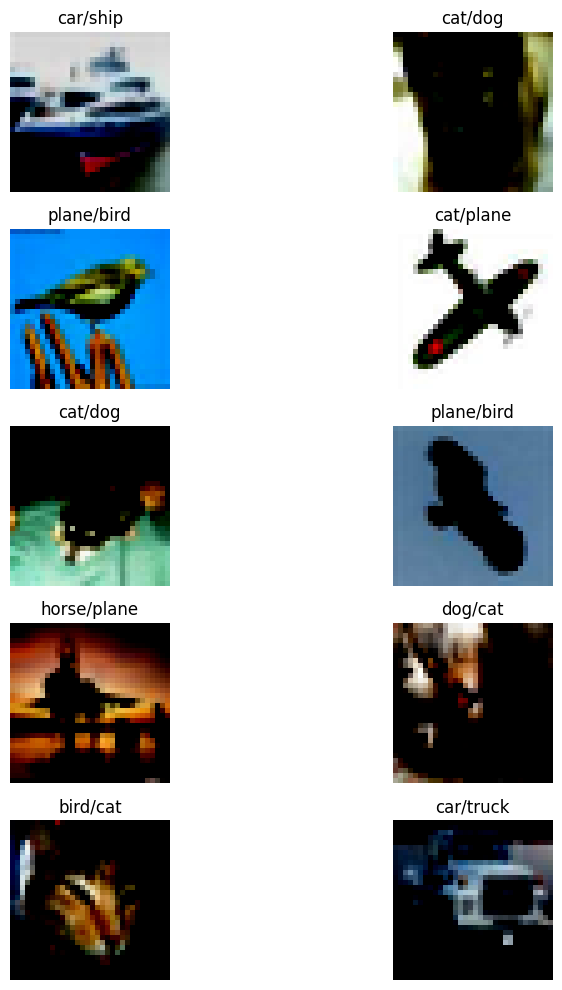

In [17]:
def denormalise_image(normalized_image):
    denormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))

    # Denormalize the image
    denormalized_image = denormalize(normalized_image)

    # Convert the tensor to a numpy array
    denormalized_image = denormalized_image.cpu().numpy()

    # Convert the image from range [-1, 1] to [0, 1]
    denormalized_image = (denormalized_image + 1) / 2

    return denormalized_image

denormalised_images = []
for image, pred, target in misclassified_images:
    denormalised_images.append((denormalise_image(image), pred, target))


fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        misclassified_image = misclassified_images[i * 2 + j]
        image = misclassified_image[0].cpu().numpy()
        axes[i, j].imshow(np.transpose(image, (1, 2, 0)))
        axes[i, j].axis('off')

        axes[i, j].set_title(f'{classes[misclassified_image[1]]}/{classes[misclassified_image[2]]}')
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Test Accuracy')

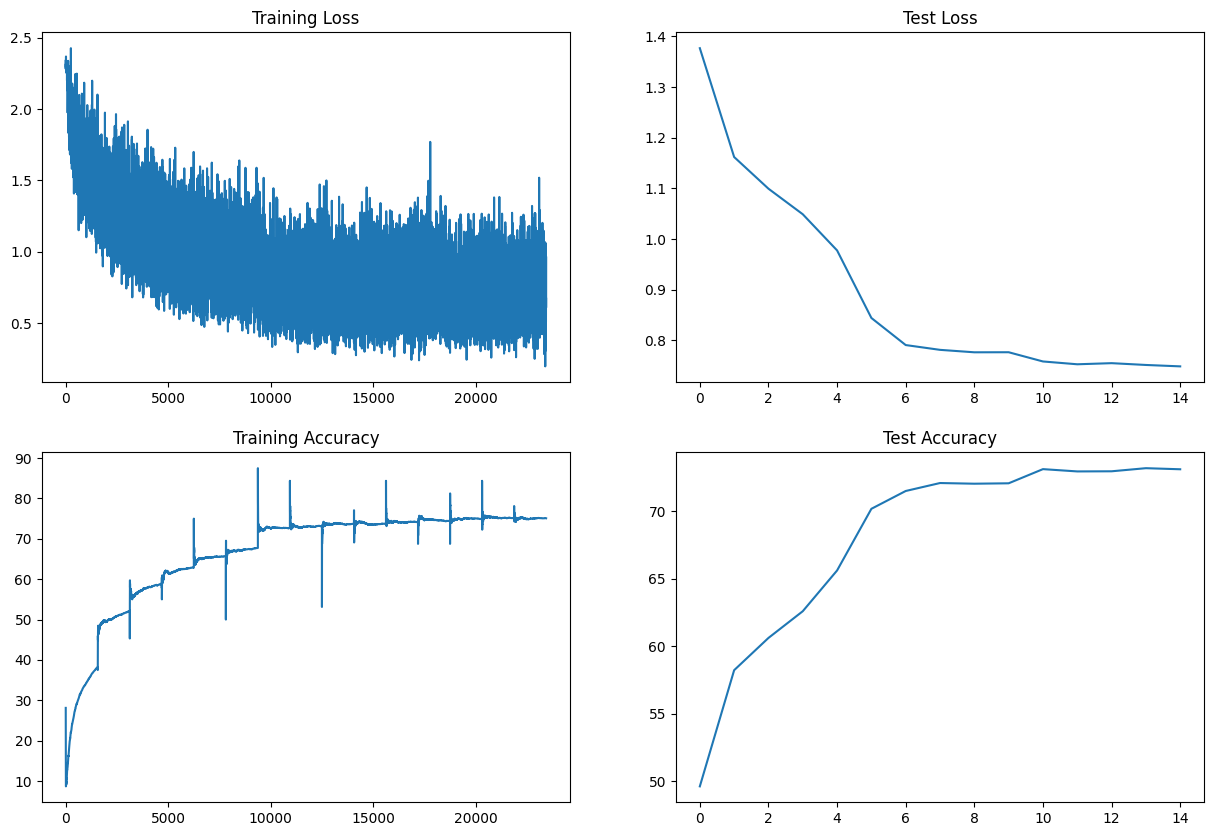

In [18]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
print(type(axs))
t = [t_items.item() for t_items in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")